In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline


/Users/xiejiayu/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

def random_like(matrix):
    ## return a random float ndarray in [0,1) with the same shape like input matrix. 
    ## Input : 
    ##    matrix: numpy ndarray
    ## Output :
    ##    out: numpy float ndarray in [0,1) 
    
    return np.random.random(np.shape(matrix))

def add_impulsive_noise(image,p = 0.1 ,show_p = False):
    ## Add impulsive noise with probability p
    ## Input : 
    ##    image: numpy ndarray
    ##    p: float in (0,1), the noise probability
    ## Output :
    ##    out: numpy ndarray 
    
    if show_p:
        print (p)
    random_image = random_like(image)
    salt_position = np.where(random_image <= p/2 )
    pepper_position = np.where((random_image > p/2) & (random_image <= p))
    noise_image = np.copy(image)
    noise_image[salt_position] = 255
    noise_image[pepper_position] = 0
    return noise_image

def load_image(filepath):
    im = Image.open(filepath)
    return im

def pil2array(image):
    return np.array(image,dtype='float32')

def array2pil(array):
    im = Image.fromarray(np.uint8(array))
    return im

def PSNR(im_label,im_correct):
    im_label = np.asarray(im_label,dtype="float32")
    im_correct = np.asarray(im_correct,dtype="float32")
    MSE = np.mean(np.square(im_label-im_correct))
    return 20*np.log10(255) - 10*np.log10(MSE)

In [3]:
class Preprocess():
    def __init__(self,file_path,img_size):
        self.im_train_list = []
        for root, dirs, files in os.walk(file_path):  
            for file in files:
                if file.split('.')[-1] == 'png':
                    im = load_image(root+'/'+file)
                    self.im_train_list.append(pil2array(im.resize(img_size)))
        self.im_size = self.im_train_list[0].shape
        
    def next_train_batch(self,batch_size=32,show_p=False,p=False):
        train_x = []
        train_y = []
        for i in range(batch_size):
            if not p:
                p = np.random.rand(1)/5
            n = np.random.randint(len(self.im_train_list))
            train_x.append(np.expand_dims(add_impulsive_noise(self.im_train_list[n],p,show_p=show_p),axis=0))
            train_y.append(np.expand_dims(self.im_train_list[n],axis=0))
        return np.vstack(train_x),np.vstack(train_y)
    
    def test_batch(self):
        train_x = []
        train_y = []
        for i in range(len(self.im_train_list)-2):
#             for p in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
            for p in [0.1,0.125,0.15,0.175,0.2]:
                train_x.append(np.expand_dims(add_impulsive_noise(self.im_train_list[i],p,show_p=False),axis=0))
                train_y.append(np.expand_dims(self.im_train_list[i],axis=0))
        return np.vstack(train_x),np.vstack(train_y)
        

In [4]:
pre = Preprocess('../train400',img_size=[96,96])

In [5]:
class CNNmodel():
    def _single_model(self,x_reshaped,name):
        conv1_res = tf.layers.conv2d(
                      inputs=x_reshaped,
                      filters=16,
                      kernel_size=[5, 5],
                      padding="same",
                      activation=tf.nn.relu,
                      name = "conv1_res" + "_" + name)

        conv1 = tf.layers.conv2d(
                  inputs=x_reshaped,
                  filters=16,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name = "conv1" + "_" + name)

        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

        conv2 = tf.layers.conv2d(
                  inputs=pool1,
                  filters=32,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name = "conv2" + "_" + name)

        conv2_up = tf.layers.conv2d_transpose(
                    inputs=conv2,
                    filters=16,
                    kernel_size=[2, 2],
                    padding="valid",
                    strides=(2, 2),
                    activation=tf.nn.relu,
                    name = "conv2_up" + "_" + name
                )

        conv6 = tf.layers.conv2d(
                  inputs=conv2_up + conv1_res,
                  filters=1,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=None,
                  name = "conv6" + "_" + name)

        return conv6
    
    def _studentT_prior(self,parameters,name,particle_var_flatten,sigma):
        n_parameters = particle_var_flatten.get_shape().as_list()[0]
        
        
        miu = np.hstack([np.reshape(v,[np.prod(v.shape)]) for v in self.single_weights])
        
        log_piror_w = n_parameters * tf.lgamma( (n_parameters+1)/2) \
                        - 0.5 * n_parameters * tf.log(n_parameters*np.pi) \
                        - n_parameters * tf.lgamma(n_parameters/2) \
                        - n_parameters * sigma \
                        - (n_parameters + 1)/2 * tf.reduce_sum(tf.log(1+tf.square( (particle_var_flatten[:-2]-miu)/tf.exp(sigma))/n_parameters))                        
        return log_piror_w


    def _gradient_log_likelihood(self,output,y_reshaped,parameters,name,particle_var_flatten,sigma,gamma):
                
        n = tf.cast(output.get_shape()[0],dtype=tf.float32)
        log_lik_data = -0.5 * n * (tf.log(2*np.pi) + gamma) - \
            1/(2*tf.exp(gamma)) * tf.reduce_sum(tf.reduce_mean(tf.square(output - y_reshaped),axis=[3]))

        log_piror_w = self._studentT_prior(parameters,name,particle_var_flatten,sigma)

        gradients = tf.gradients( 5000 * log_lik_data + log_piror_w ,parameters)
        return gradients,log_lik_data,log_piror_w
    
    def _reduce_median(self,v):    
        v = tf.reshape(v, [-1])
        m = v.get_shape()[0]//2

        def true_fn():
            m = v.get_shape()[0]//2+1
            return tf.reduce_mean(tf.nn.top_k(v, m).values[m-2:])

        def false_fn():
            m = v.get_shape()[0]//2+1
            return tf.nn.top_k(v, m).values[m-1]

        median = tf.cond(tf.equal( tf.mod(tf.cast(v.get_shape()[0],dtype=tf.float32) , 2),0),true_fn,false_fn)

        return median,v

    def _tf_pairwise_dists(self,A):
        r = tf.reduce_sum(A*A, 1)
        # turn r into column vector
        r = tf.reshape(r, [-1, 1])
        D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
        return D

    def _tf_rbf_kernel(self,theta,h=-1):
        pairwise_dists = self._tf_pairwise_dists(theta)

        if h < 0: # if h < 0, using median trick
            h1,v = self._reduce_median(pairwise_dists)  
            h = tf.sqrt(0.5 * h1 / tf.log(tf.cast(theta.get_shape()[0]+1,dtype=tf.float32)))
            self.h = [h,h1]
        Kxy = tf.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -(Kxy @ theta)
        sumkxy = tf.reduce_sum(Kxy, axis=1,keep_dims=True)

        dxkxy = dxkxy + theta*sumkxy
        dxkxy = dxkxy / (h**2)

        return (Kxy,dxkxy)
    
    def _package_gradient_varaibles(self,logits_list,y_reshaped,paritcles_vars_flatten):
        tgra_vars = tf.trainable_variables()
        particles_vars = []
        paritcles_grads_flatten_list = []
        self.log_likeli_list = []
        self.log_prior_list = []
        self.log_cost_list = []
        
        for i in range(self.particles):
            output = logits_list[i] 
            particle_list_var = []
            paritcles_grad_flatten = []
            
            ## get all varaibles belong to this particle
            for varaible in tgra_vars:
                if "particle_"+str(i)+"_" in varaible.name:
                    particle_list_var.append(varaible)
                    
            particle_var_flatten = paritcles_vars_flatten[i,:]
            sigma = self.sigma_list[i]
            gamma = self.gamma_list[i]
            gradients,log_lik_data,log_piror_w = self._gradient_log_likelihood(output,y_reshaped,particle_list_var,"particle_"+str(i),particle_var_flatten,sigma,gamma)
            
            self.log_likeli_list.append(log_lik_data)
            self.log_prior_list.append(log_piror_w)
            self.log_cost_list.append(log_lik_data+log_piror_w)
            
            ## flatten gradients and concat to one row
            for gradient in gradients:
                paritcles_grad_flatten.append(tf.reshape(gradient,[-1]))
            paritcles_grads_flatten_list.append(tf.reshape(tf.concat(paritcles_grad_flatten,axis=-1),[1,-1]))  
            particles_vars.append(particle_list_var)
            
        self.log_likeli_list = tf.reduce_mean(self.log_likeli_list)
        self.log_prior_list = tf.reduce_mean(self.log_prior_list)
        self.log_cost_list = tf.reduce_mean(self.log_cost_list)
        ## concat all the particles parameters.
        paritcles_grads_flatten_list = tf.concat(paritcles_grads_flatten_list,axis=0)
        return particles_vars,paritcles_grads_flatten_list
        
    def _package_varaibles(self):
        tgra_vars = tf.trainable_variables()
        particles_vars = []
        paritcles_vars_flatten = []
        for i in range(self.particles):
            particle_list_var = []
            particle_list_var_flatten = []
            for varaible in tgra_vars:
                if "particle_"+str(i)+"_" in varaible.name:
                    particle_list_var.append(varaible)
                    particle_list_var_flatten.append(tf.reshape(varaible,[-1]))
            particles_vars.append(particle_list_var)
            paritcles_vars_flatten.append(tf.reshape(tf.concat(particle_list_var_flatten,axis=-1),[1,-1]))
        paritcles_vars_flatten = tf.concat(paritcles_vars_flatten,axis=0)
        return particles_vars,paritcles_vars_flatten
         
    def _unpack_varaibles(self,varaible_list,gradients):
        praticles_grads_list = []
        for i in range(self.particles):
            total_count = 0
            gradients_particle = gradients[i,:]
            gradients_list = []
            for var in varaible_list[i]:
                add = tf.reduce_prod(tf.shape(var))
                cur = total_count + add
                gradients_list.append(tf.reshape(gradients_particle[total_count:cur],tf.shape(var)))
                total_count = cur
            praticles_grads_list.append(gradients_list)
            
        grad_var_list = []
        for var_partocle,grad_particle in zip(varaible_list,praticles_grads_list):
            for var,grad in zip(var_partocle,grad_particle):
                grad_var_list.append((grad,var))
                
        return grad_var_list
    
    def _svgd(self,logits_list,y_reshaped):
        self.gamma_list = []
        self.sigma_list = []
        for i in range(self.particles):
            log_gamma = tf.Variable(1,dtype=tf.float32,name = "log_gamma_"+"particle_"+str(i)+"_")
            log_sigma = tf.Variable(1,dtype=tf.float32,name = "sigma_2_"+"particle_"+str(i)+"_")
            self.gamma_list.append(log_gamma)
            self.sigma_list.append(log_sigma)
        
        particles_vars,paritcles_vars_flatten = self._package_varaibles()
        _,gradients = self._package_gradient_varaibles(logits_list,y_reshaped,paritcles_vars_flatten)
        kxy, dxkxy = self._tf_rbf_kernel(paritcles_vars_flatten, h = -1) 
        
        grad_theta = (tf.matmul(kxy, gradients) + dxkxy) / self.particles
        grad_var = self._unpack_varaibles(particles_vars,-grad_theta)
        return grad_var
        
    def __init__(self,learning_rate,particles=1):
        self.graph = tf.Graph()
        self.particles = particles
        with self.graph.as_default():
            self.x = tf.placeholder(name="input_x",shape=[None,None,None],dtype=tf.float32)
            self.y = tf.placeholder(name="input_y",shape=[None,None,None],dtype=tf.float32)

            x_reshaped = tf.expand_dims(self.x,axis=-1)
            y_reshaped = tf.expand_dims(self.y,axis=-1)
                        
            self._load_single()
            
            self.logits_list = []
            for i in range(particles):
                self.logits_list.append(tf.expand_dims(self._single_model(x_reshaped,"particle_"+str(i)+"_"),axis=0))

            self.output = tf.reduce_mean(tf.concat(self.logits_list,axis=0),axis=0)

            self.l1_loss = tf.reduce_mean(tf.square(self.output - y_reshaped))
                    
            self.train_loss = self.l1_loss
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate)

            self.l2_train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.train_loss)
            

            
            self.svgd_grad_var = self._svgd(self.logits_list,y_reshaped)
            
            self.train_op = self.optimizer.apply_gradients(self.svgd_grad_var)
            
            self.prior_train_op = tf.train.AdamOptimizer(learning_rate).minimize(-self.log_prior_list)
            
            self.prior_gradients = tf.train.AdamOptimizer(learning_rate).compute_gradients(-self.log_prior_list,var_list= tf.trainable_variables())
            
            self.adam_apply_train_op = self.optimizer.apply_gradients(self.prior_gradients)
            
            MSE = tf.reduce_mean(tf.square(y_reshaped - self.output)) 
            self.psnr = 20*self.log10(255) - 10*self.log10(MSE)
            
    def train(self,epoches,pre,test_pre,batch_size=128,init=True):
        if init:
            self.sess = tf.InteractiveSession(graph=self.graph)
            init = tf.global_variables_initializer()
            self.sess.run(init)
            self.saver = tf.train.Saver()
            self.best_performance = 0

        test_x,test_y = test_pre.test_batch()
        test_feed_dict = {self.x:test_x,
                        self.y:test_y}
        
        for i in range(epoches):
            x,y = pre.next_train_batch(batch_size=batch_size)
            feed_dict = {self.x:x,
                        self.y:y}
            _,loss,l1_loss,psnr_value,sigma,gamma,h,log_likeli_list,log_prior_list,log_cost_list = self.sess.run([self.train_op,self.train_loss,self.l1_loss,self.psnr,
                                                                     self.sigma_list,
                                                                     self.gamma_list,
                                                                      self.h,
                                                                    self.log_likeli_list,
                                                                    self.log_prior_list,
                                                                    self.log_cost_list],
                                   feed_dict=feed_dict)
            
            if (i+1)%100 == 0:
                print (i,"LOSS:",loss,"psnr:",psnr_value,"sigma:",np.mean(sigma),"gamma:",np.mean(gamma),"h",h,
                       "log_likeli_list:",log_likeli_list,"log_prior_list:",log_prior_list,
                      "log_cost_list:",log_cost_list)
                performance = self.test_batch(test_feed_dict)
                if performance > self.best_performance:
                    self.save(self.saver)
                    print ("BEST PERFORMANCE:",performance)
                    self.best_performance = performance
    def log10(self,x):
        return tf.log(tf.cast(x,dtype=tf.float32))/tf.log(10.)
                
    def save(self,saver):
        if not saver:
            saver = tf.train.Saver()
        saver.save(self.sess, './CNN')
                
    def test_batch(self,test_feed_dict):
        
        psnr = self.sess.run(self.psnr,feed_dict=test_feed_dict)
        print (psnr)
        return psnr
    
    def load(self,last_best_performance):
        if last_best_performance:
            self.best_performance = last_best_performance
        else:
            self.best_performance = 0
        self.sess = tf.InteractiveSession(graph=self.graph)
        self.saver = tf.train.Saver()
        self.saver.restore(self.sess, "./CNN")
        
    def _load_single(self):
        self.single_weights = np.load("weights.npy")

In [6]:
model = CNNmodel(1e-3,particles = 20)
# model.load(29.3479)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
test_pre = Preprocess('../Test/Set12/256',img_size=[256,256])

In [ ]:
model.train(40000,pre,test_pre,init = False,batch_size=64)

99 LOSS: 151.655 psnr: 26.3222 sigma: -0.816854 gamma: 13.3473 h [8.7445526, 465.61224] log_likeli_list: -8.51216 log_prior_list: -4510.47 log_cost_list: -4518.98
28.8395
199 LOSS: 155.336 psnr: 26.2181 sigma: -0.820024 gamma: 13.3693 h [8.7008562, 460.97055] log_likeli_list: -8.50867 log_prior_list: -4487.33 log_cost_list: -4495.84
28.7777
299 LOSS: 173.632 psnr: 25.7345 sigma: -0.823196 gamma: 13.3945 h [8.659833, 456.63403] log_likeli_list: -8.58581 log_prior_list: -4464.34 log_cost_list: -4472.93
28.2846
399 LOSS: 85.7185 psnr: 28.8001 sigma: -0.826571 gamma: 13.4122 h [8.6138906, 451.80173] log_likeli_list: -8.09187 log_prior_list: -4439.56 log_cost_list: -4447.66
28.2837
499 LOSS: 69.4128 psnr: 29.7164 sigma: -0.829832 gamma: 13.431 h [8.5715322, 447.36926] log_likeli_list: -8.00044 log_prior_list: -4415.49 log_cost_list: -4423.49
28.0762
599 LOSS: 77.3507 psnr: 29.2462 sigma: -0.833341 gamma: 13.4461 h [8.5301723, 443.06232] log_likeli_list: -8.04801 log_prior_list: -4390.55 log

27.41
4899 LOSS: 166.492 psnr: 25.9169 sigma: -0.963287 gamma: 13.6763 h [7.400816, 333.50964] log_likeli_list: -8.45889 log_prior_list: -3447.89 log_cost_list: -3456.35
28.3823
4999 LOSS: 183.975 psnr: 25.4832 sigma: -0.965428 gamma: 13.6807 h [7.3847609, 332.06421] log_likeli_list: -8.54573 log_prior_list: -3432.27 log_cost_list: -3440.82
28.62
5099 LOSS: 136.853 psnr: 26.7683 sigma: -0.967652 gamma: 13.6787 h [7.3648868, 330.2793] log_likeli_list: -8.32106 log_prior_list: -3415.89 log_cost_list: -3424.21
27.5907
5199 LOSS: 129.535 psnr: 27.0069 sigma: -0.969848 gamma: 13.6718 h [7.3477855, 328.74725] log_likeli_list: -8.28872 log_prior_list: -3399.93 log_cost_list: -3408.22
27.9835
5299 LOSS: 144.289 psnr: 26.5385 sigma: -0.972031 gamma: 13.6693 h [7.3259501, 326.79626] log_likeli_list: -8.38175 log_prior_list: -3384.29 log_cost_list: -3392.67
28.7655
5399 LOSS: 172.94 psnr: 25.7519 sigma: -0.974392 gamma: 13.6554 h [7.3082805, 325.22174] log_likeli_list: -8.46768 log_prior_list: -3

28.8186
9699 LOSS: 51.3704 psnr: 31.0237 sigma: -1.05342 gamma: 13.6233 h [6.3917603, 248.7655] log_likeli_list: -7.94862 log_prior_list: -2793.98 log_cost_list: -2801.93
27.8437
9799 LOSS: 166.993 psnr: 25.9038 sigma: -1.05509 gamma: 13.6147 h [6.3720746, 247.23553] log_likeli_list: -8.46596 log_prior_list: -2781.84 log_cost_list: -2790.31
28.8406
9899 LOSS: 47.6304 psnr: 31.352 sigma: -1.05653 gamma: 13.6275 h [6.354435, 245.86859] log_likeli_list: -7.93416 log_prior_list: -2771.6 log_cost_list: -2779.53
27.1334
9999 LOSS: 56.3197 psnr: 30.6242 sigma: -1.0582 gamma: 13.6232 h [6.3411083, 244.83838] log_likeli_list: -7.96332 log_prior_list: -2759.07 log_cost_list: -2767.03
28.5908
10099 LOSS: 83.8021 psnr: 28.8983 sigma: -1.05975 gamma: 13.6149 h [6.3217473, 243.34558] log_likeli_list: -8.09978 log_prior_list: -2747.54 log_cost_list: -2755.64
28.7057
10199 LOSS: 148.504 psnr: 26.4134 sigma: -1.06119 gamma: 13.6262 h [6.3075633, 242.25482] log_likeli_list: -8.37106 log_prior_list: -273

28.6209
14499 LOSS: 79.3053 psnr: 29.1378 sigma: -1.13353 gamma: 13.5998 h [6.1027856, 226.78033] log_likeli_list: -8.07025 log_prior_list: -2211.29 log_cost_list: -2219.36
28.7956
14599 LOSS: 47.8166 psnr: 31.335 sigma: -1.13549 gamma: 13.599 h [6.0985627, 226.46661] log_likeli_list: -7.92823 log_prior_list: -2197.35 log_cost_list: -2205.28
28.1525
14699 LOSS: 102.455 psnr: 28.0255 sigma: -1.13682 gamma: 13.6121 h [6.100915, 226.64136] log_likeli_list: -8.15865 log_prior_list: -2187.94 log_cost_list: -2196.09
29.2586
14799 LOSS: 140.652 psnr: 26.6494 sigma: -1.13881 gamma: 13.6052 h [6.1007738, 226.63086] log_likeli_list: -8.37403 log_prior_list: -2173.81 log_cost_list: -2182.19
29.1852
14899 LOSS: 76.8711 psnr: 29.2732 sigma: -1.14056 gamma: 13.5944 h [6.1037698, 226.85352] log_likeli_list: -8.04973 log_prior_list: -2160.5 log_cost_list: -2168.55
29.1187
14999 LOSS: 145.251 psnr: 26.5096 sigma: -1.14217 gamma: 13.6058 h [6.1111841, 227.40497] log_likeli_list: -8.38254 log_prior_list:

29.2569
19299 LOSS: 180.293 psnr: 25.571 sigma: -1.22263 gamma: 13.6077 h [6.355299, 245.93549] log_likeli_list: -8.5193 log_prior_list: -1566.16 log_cost_list: -1574.68
28.7917
19399 LOSS: 53.1061 psnr: 30.8794 sigma: -1.22458 gamma: 13.6111 h [6.3599725, 246.2973] log_likeli_list: -7.95205 log_prior_list: -1551.81 log_cost_list: -1559.77
28.7829


In [7]:
test_pre = Preprocess('../Test/Set12/bird',img_size=[256,256])

In [8]:
x,y = test_pre.next_train_batch(batch_size=1,show_p=True,p=0.1)
feed_dict = {model.x:x,model.y:y}

0.1


In [9]:
predict,psnr = model.sess.run([model.output,model.psnr],feed_dict=feed_dict)

In [10]:
print (psnr)

30.0454


In [90]:
array2pil(np.reshape(predict,[x.shape[1],x.shape[1]])).resize([x.shape[1],x.shape[1]])

In [91]:
array2pil(np.reshape(y,[x.shape[1],x.shape[1]])).resize([x.shape[1],x.shape[1]])

In [92]:
array2pil(np.reshape(x,[x.shape[1],x.shape[1]])).resize([x.shape[1],x.shape[1]])

In [11]:
def variaence(model,feed_dict):
    logits,log_sigma = model.sess.run([model.logits_list,model.sigma_list],feed_dict=feed_dict)
    
    logits = np.squeeze(logits,axis=(0,-1) )
    print (1/np.exp(log_sigma))
    
    mean_logtis = np.mean(logits,axis=0)
    
    variance = np.mean( np.reshape(np.exp(log_sigma),[-1,1,1]) +  np.square(logits),axis=0) - np.square(mean_logtis)
    return variance

In [12]:
var = variaence(model,feed_dict)
print (var.shape)

[ 4.74294853  3.09635115  3.56009984  3.78472233  3.09480238  2.92725015
  2.96856737  3.17534304  3.68609595  3.19974518  3.45896864  3.12338305
  3.1217711   3.83325815  3.15854073  2.99429107  3.69331217  2.99358177
  4.28918314  3.05351806]
(256, 256)


[[], []]

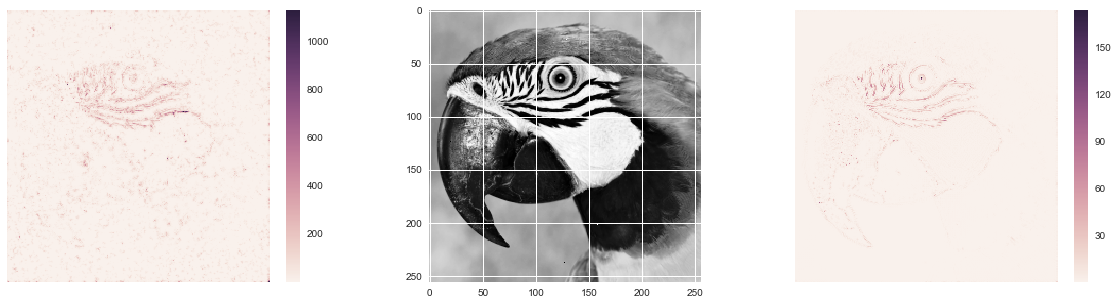

In [50]:
start = 0
end = 256
plt.figure(figsize=(20,5)) 
plt.subplot(131)
g = sns.heatmap(var[start:end,start:end])
g.set(yticks=[],xticks=[])
plt.subplot(132)
plt.imshow(-np.squeeze(x)[start:end,start:end]) 
plt.subplot(133)
g = sns.heatmap(np.abs(np.squeeze(predict)-np.squeeze(y))[start:end,start:end])
g.set(yticks=[],xticks=[])


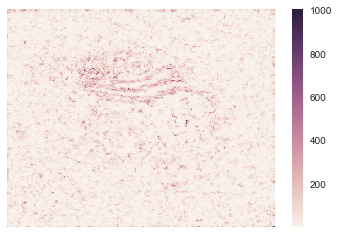

In [93]:
g = sns.heatmap(var[start:end,start:end])
g.set(yticks=[],xticks=[])
plt.savefig('Varbird_02_.png')

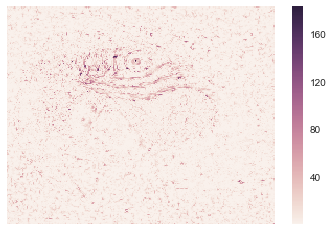

In [94]:
g = sns.heatmap(np.abs(np.squeeze(predict)-np.squeeze(y))[start:end,start:end])
g.set(yticks=[],xticks=[])
plt.savefig('errorbird_02_.png')

In [13]:
err = np.abs(np.squeeze(predict)-np.squeeze(y))

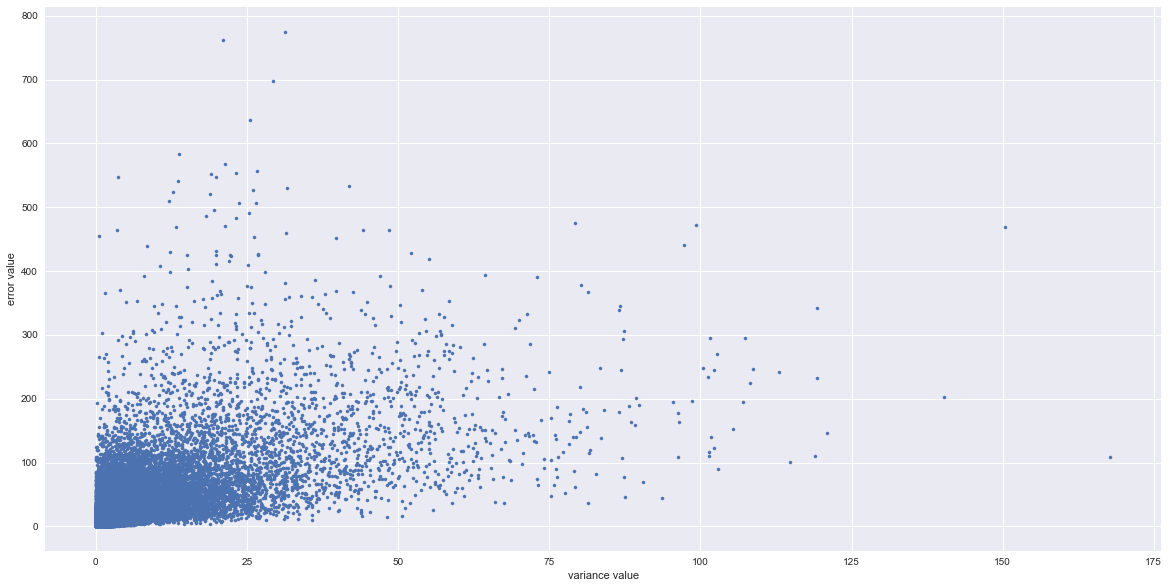

In [25]:
plt.figure(figsize=(20,10)) 
plt.scatter(err.flatten(),var.flatten(),s=10)
plt.xlabel("variance value")
plt.ylabel("error value")
plt.savefig("sca_xvar_yerr.png")

(array([  2.00000000e+00,   2.20000000e+01,   1.87000000e+02,
          3.53400000e+03,   6.04240000e+04,   1.19700000e+03,
          1.45000000e+02,   2.10000000e+01,   3.00000000e+00,
          1.00000000e+00]),
 array([-0.73495901, -0.56821901, -0.40147902, -0.23473902, -0.06799903,
         0.09874097,  0.26548096,  0.43222095,  0.59896095,  0.76570094,
         0.93244094]),
 <a list of 10 Patch objects>)

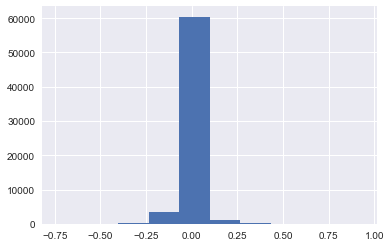

In [88]:
plt.hist(err.flatten()/np.max(err) - var.flatten()/np.max(var))

In [73]:
error_map = np.sqrt(np.square(np.squeeze(predict)-np.squeeze(y)))
print (np.mean(np.abs(var/np.max(var) - error_map/np.max(error_map))))
# sns.heatmap(np.abs(var/np.max(var) - error_map/np.max(error_map)))

0.0120014


In [19]:
logits_list = model.sess.run(model.logits_list,feed_dict=feed_dict)

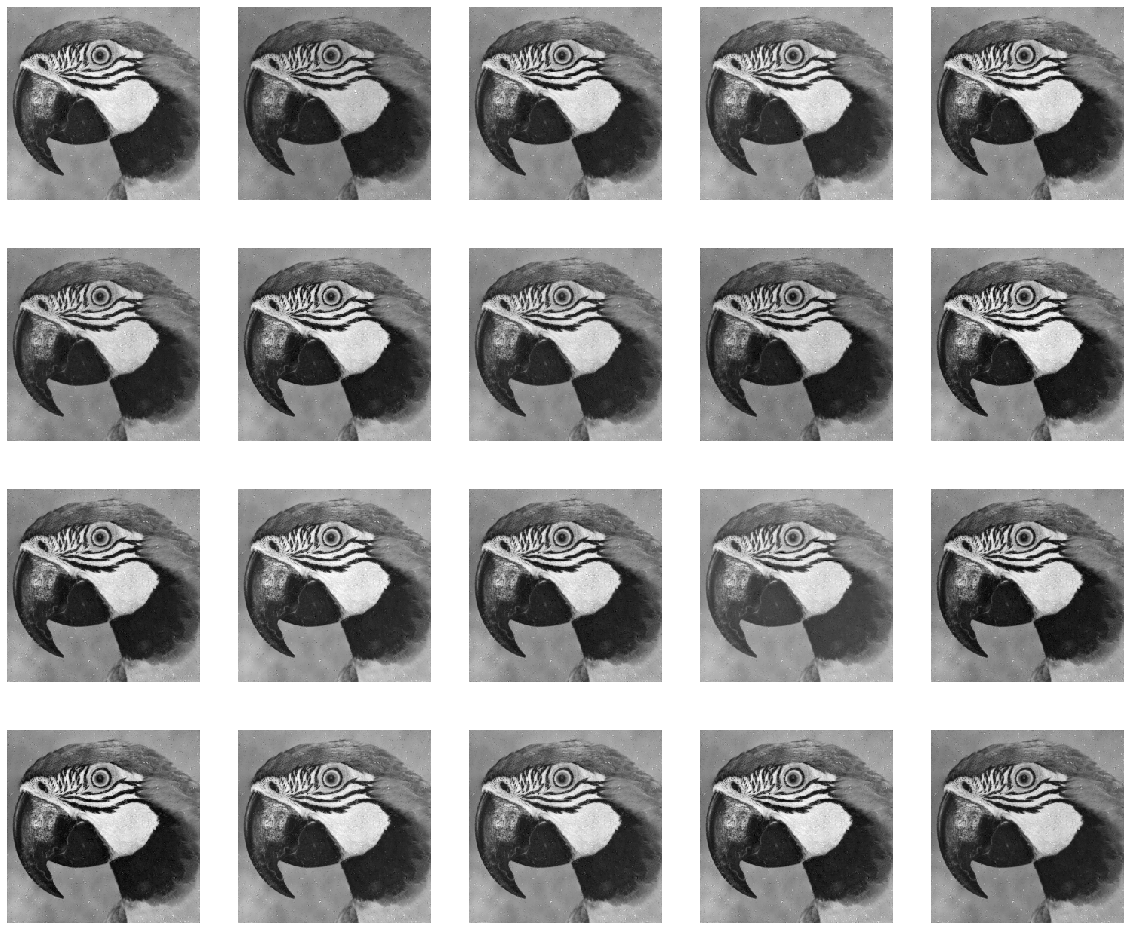

In [24]:
plt.figure(figsize=(20,17)) 
for i in range(len(logits_list)):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.squeeze(logits_list[i]), cmap='gray')
plt.savefig("20_image.png")

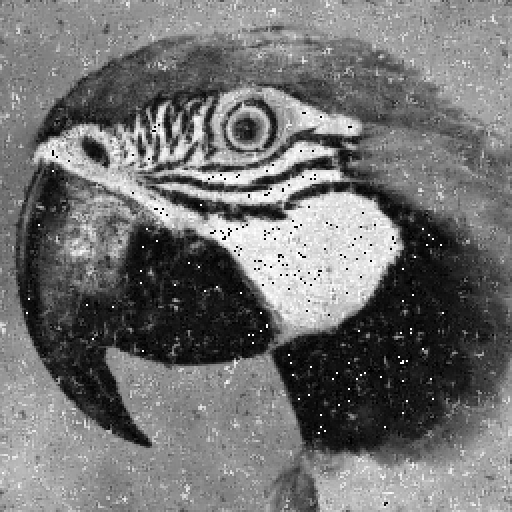

In [294]:
array2pil(np.reshape(logits_list[0],[x.shape[1],x.shape[1]])).resize([x.shape[1]*2,x.shape[1]*2]) #np.squeeze(logits_list[0])

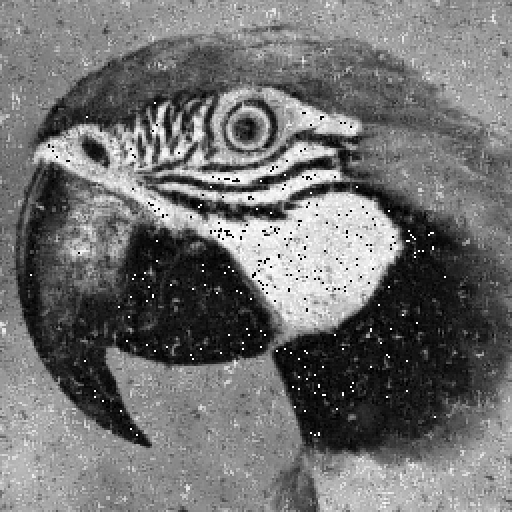

In [295]:
array2pil(np.reshape(logits_list[1],[x.shape[1],x.shape[1]])).resize([x.shape[1]*2,x.shape[1]*2]) #np.squeeze(logits_list[0])

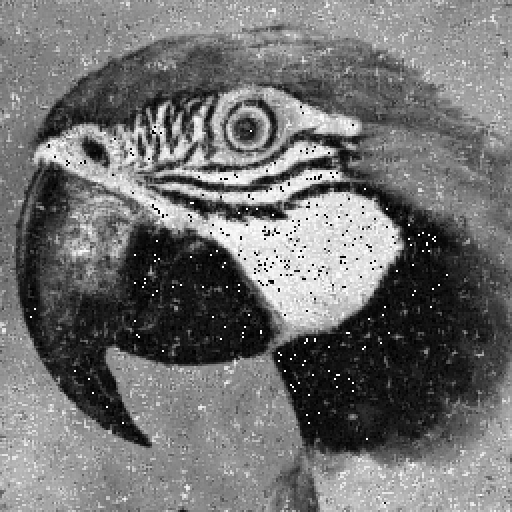

In [296]:
array2pil(np.reshape(logits_list[2],[x.shape[1],x.shape[1]])).resize([x.shape[1]*2,x.shape[1]*2]) #np.squeeze(logits_list[0])